## AutoEncoder
### structure
    3 layer conv and downsample          
    3 layer transpose conv upsample
    loss: Mean Square Error
    optimizer: Adam
### functions
    import torch.nn as nn
    3 layer conv and downsample
        conv:  nn.Conv2d(inputlayerchannels,outputlayerchannels,kernelsize,padding)
        downsample:nn.MaxPool2d(2,2)
    3 layer transpose conv upsample: nn.ConvTranspose2d(inputlayerchannels,outputlayerchannels,kernelsize,stride=2)
    activation function:import torch.nn.functional as F   F.relu   F.sigmoid
    loss: Mean Square Error   nn.MSELoss(predicts,targets)
    optimizer: Adam        torch.optim.Adam(model.parameters(),lr=0.001)
    Dataloader:torch.utils.data.DataLoader
    reshape:  certainTensor.view(batch_size,channel,height,width)
    get the output value of a layer: outputofalayer.detach().numpy() can get the auto_grad values away only keep the value of layeroutput
### how to organize code
    Write a class(nn.Module) to contain the whole network sturcture:__init__ and forward need to rewrite. 
    Conv and Transpose_Conv should keep the weights, while pool and relu don't need to keep paras. And nn calls layers, Function calls funcs,layers have paras so they should be the variable of network class.
    instanciate the network class.
    Define Loss 
    Define opitimizer
    Image transform to Tensor, and load use Dataloader
    iterate dataloader get the input and target batch to TRAIN the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs,targets)
        loss.backward()
        optimizer.step()
        loss.item()*images.size(0) get total batch loss
        train_loss update(each epoch or each batch)
    TEST the model: get some data from test set, eg. one batch data. output = model(test_data)get the output. And RESHAPE 
    some visualize: fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
    for noisy_imgs, row in zip([noisy_imgs, output], axes):
        for img, ax in zip(noisy_imgs, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

## 1. Download Dataset

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data',train=True,download=True,transform=transform)
test_data = datasets.MNIST(root='data',train=False,download=True,transform=transform)

 95%|███████████████████████████████████████████████████████████████▍   | 9379840/9912422 [00:10<00:00, 1064189.91it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz



0it [00:00, ?it/s]
  0%|                                                                                        | 0/28881 [00:00<?, ?it/s]
32768it [00:00, 78411.27it/s]                                                                                          

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz



0it [00:00, ?it/s]
 80%|█████████████████████████████████████████████████████▌             | 1318912/1648877 [00:01<00:00, 1466873.60it/s]
1654784it [00:01, 1066127.20it/s]                                                                                      

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz



0it [00:00, ?it/s]
  0%|                                                                                         | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 21565.91it/s]                                                                                           

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


9920512it [00:29, 1064189.91it/s]                                                                                      

## 2.  Step 1: write a class of network

Write a class(nn.Module) to contain the whole network sturcture:__init__ and forward need to rewrite.        
Conv and Transpose_Conv should keep the weights, while pool and relu don't need to keep paras. And nn calls layers, Function calls funcs,layers have paras so they should be the variable of network class.        
instanciate the network class.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class  Denoiser(nn.Module):
    def __init__(self):
        super(Denoiser,self).__init__()
        self.conv_1 = nn.Conv2d(1,32,3,padding = 1)
        self.conv_2 = nn.Conv2d(32,16,3,padding = 1)
        self.conv_3 = nn.Conv2d(16,8,3,padding = 1)
        self.pool = nn.MaxPool2d(2,2)
        self.t_conv_1 = nn.ConvTranspose2d(8,8,3,stride = 2)
        self.t_conv_2 = nn.ConvTranspose2d(8,16,2,stride = 2)
        self.t_conv_3 = nn.ConvTranspose2d(16,32,2,stride = 2)
        self.conv_out = nn.Conv2d(32,1,3,padding = 1)
    def forward(self,x):
        # encode
        x = self.conv_1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.relu(self.conv_2(x))
        x = self.pool(x)
        x = F.relu(self.conv_3(x))
        x = self.pool(x)
        # decode
        x = F.relu(self.t_conv_1(x))
        x = F.relu(self.t_conv_2(x))
        x = F.relu(self.t_conv_3(x))
        # output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))
        return x
model = Denoiser()
print(model)

Denoiser(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv_1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv_2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv_3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## 3. Step 2: 
Define Loss      
Define opitimizer        

In [6]:
Criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

## 4. Step 3: 
Data transform to Tensor, and load data using DataLoader
DataLoader contain Sampler, BatchSampler, and dataset, allowing us sample the dataset.

In [7]:
# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([20, 1, 28, 28])


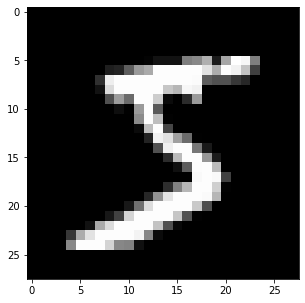

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [10]:
# how to get batches when training

epochs = 2
for i in range(epochs):
    count = 0
    for data in train_loader:
        image,_ = data
        print(image.shape)
        count += 1
        if count>5:
            break

torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])


## 5. Step 4: Train
iterate dataloader get the input and target batch to TRAIN the model         
    optimizer.zero_grad()        
    outputs = model(inputs)        
    loss = loss_function(outputs,targets)          
    loss.backward()         
    optimizer.step()         
    loss.item()*images.size(0) get total batch loss        
    train_loss update(each epoch or each batch)          

In [ ]:
n_epochs = 20
noise_factor = 0.5
for epoch in range(n_epochs):
    train_loss = 0.0
    for data in train_loader:
        images,_ = data
        
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        optimizer.zero_grad()
        outputs = model(noisy_imgs)